# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [269]:
# !pip install folium

In [270]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [271]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [272]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train = pd.read_csv('train.csv')

In [273]:
train.shape

(1458644, 11)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [274]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.drop(columns='dropoff_datetime', inplace=True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

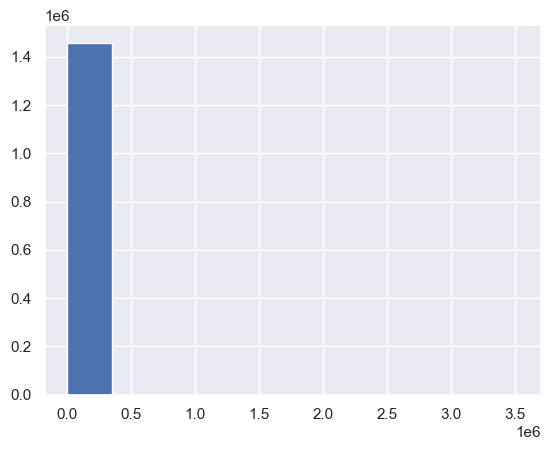

In [275]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train['trip_duration'].tolist())
plt.show()


**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

По гистограмме ясно, что большая часть значений сконцентрирована по крайней мере до 500000 и есть некоторое количество выбросов, которое мешает хорошо проанализировать распределение. 

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?
Длительность поездки на такси может быть совершенно разная (мы, конечно, ожидаем разумные пределы). Однако в наших данных она измеряется в минутах, что может быть не очень удобно, потому что есть поездки как на 5 минут, так и на 6 часов, поэтому полезно привести данные к удоному формату и при этом не работать с очень большими числами, и при этом функция логарифмирования обратима, то есть мы легко вернемся к первоначальным данным.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Понятно, что оптимизация RMSE и MSE эквивалентна.

Если $\hat{a}(x_i) = \log{(a(x_i)+1)}$, $\hat{y}_i = \log{(y_i + 1)}$, то:

MSE для $\hat{a}(x_i)$: $\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$ - а это RMSLE для $a(x_i)$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

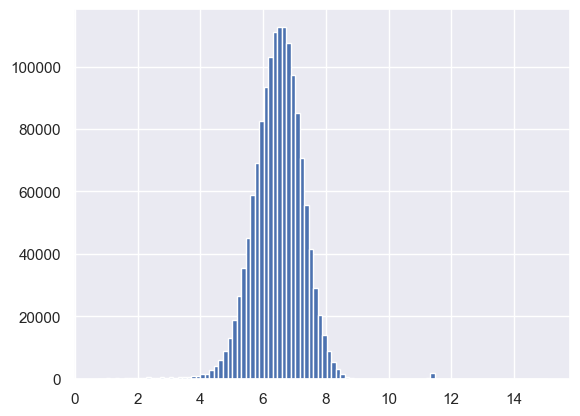

In [276]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['log_trip_duration'] = np.log1p(train['trip_duration'])
plt.hist(train['log_trip_duration'].to_numpy(), bins=100)
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [277]:
def rmsle(log1p_y_true, log1p_y_pred): 
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    dot = np.dot(log1p_y_true - log1p_y_pred, log1p_y_true - log1p_y_pred)
    return np.sqrt(dot / log1p_y_true.shape[0])

l = train['log_trip_duration'].shape[0]
log1p_y_pred = np.full((l, ), train['log_trip_duration'].mean())


In [278]:
rmsle_best_const = rmsle(train['log_trip_duration'], log1p_y_pred)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411524


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

<Axes: xlabel='pickup_datetime', ylabel='count'>

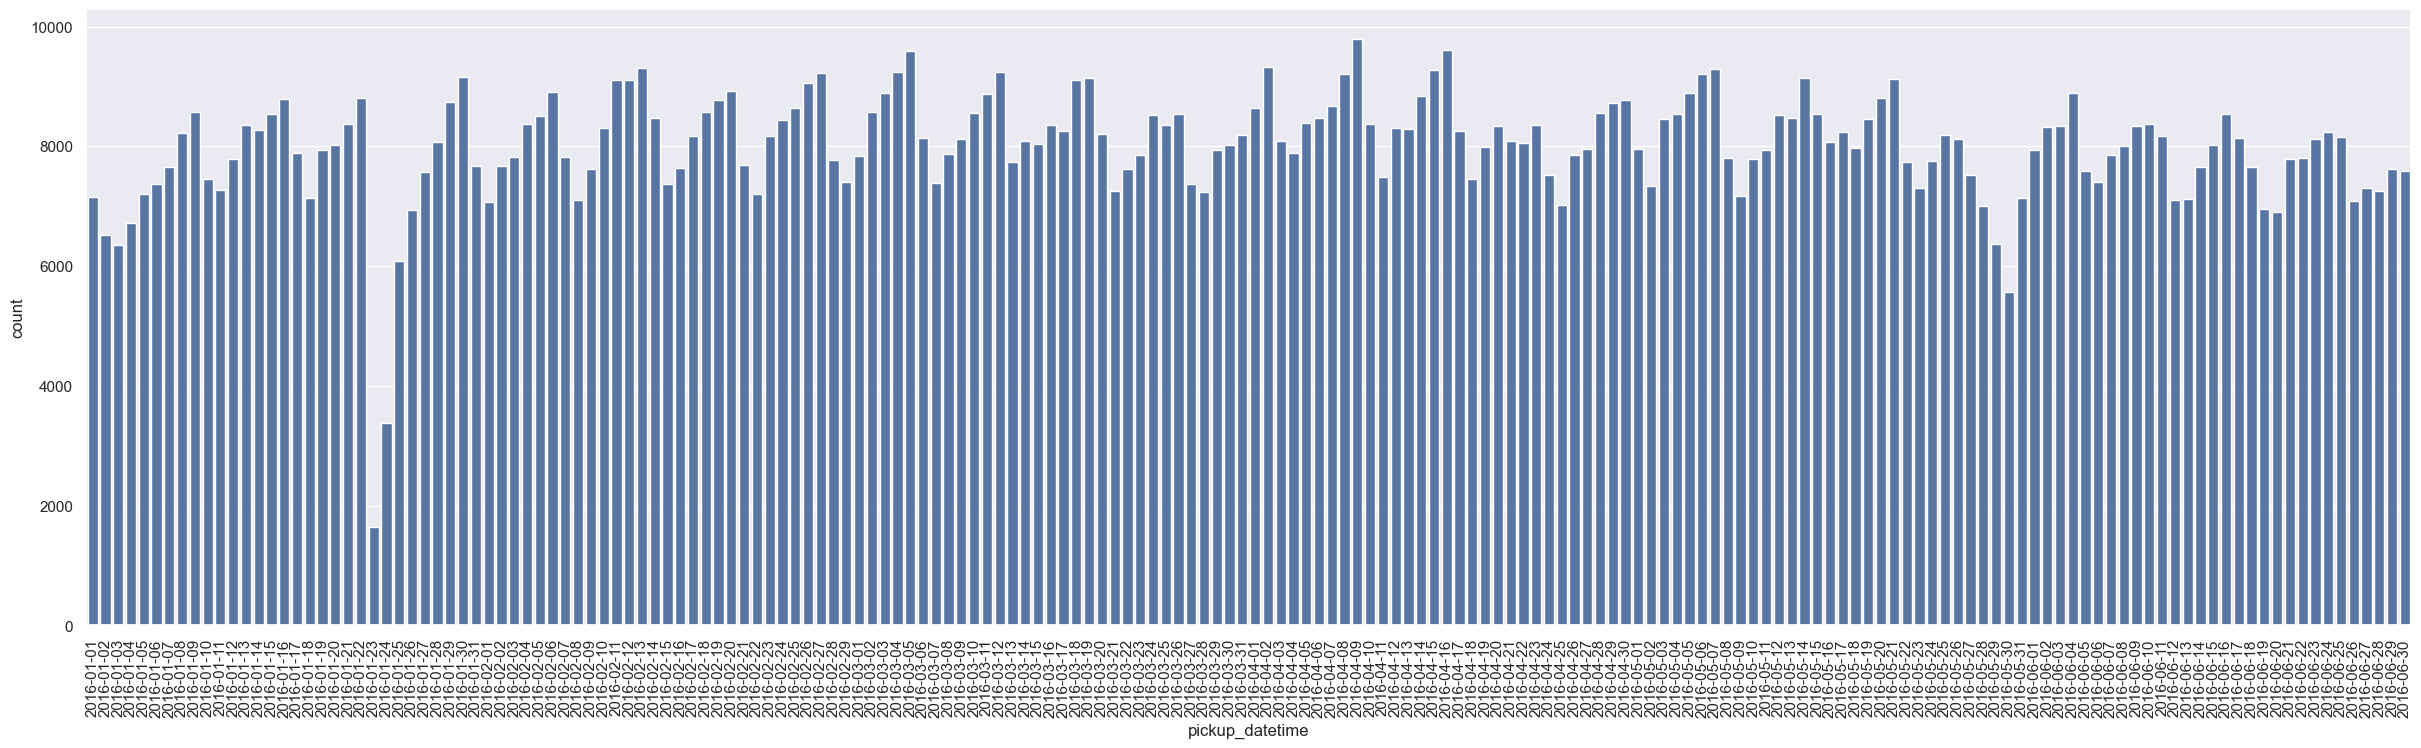

In [279]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(30,8))
plt.xticks(rotation=90)
sns.countplot(x=train['pickup_datetime'].dt.date.sort_values())



**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Скачки происходили из-за аномальной погоды, сама я вижу только 23,24 января как аномалию, но доверимся человеку из kaggle (https://www.kaggle.com/competitions/nyc-taxi-trip-duration/discussion/38591)


In [280]:
# взято из ссылки выше
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date
train['anomaly'] = 0
train.loc[(train['pickup_datetime'].dt.date).isin(weather_event),'anomaly'] = 1


Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [281]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek


In [282]:
train['day_of_year'] = train['pickup_datetime'].dt.day_of_year

In [283]:
train['hour'] = train['pickup_datetime'].dt.hour

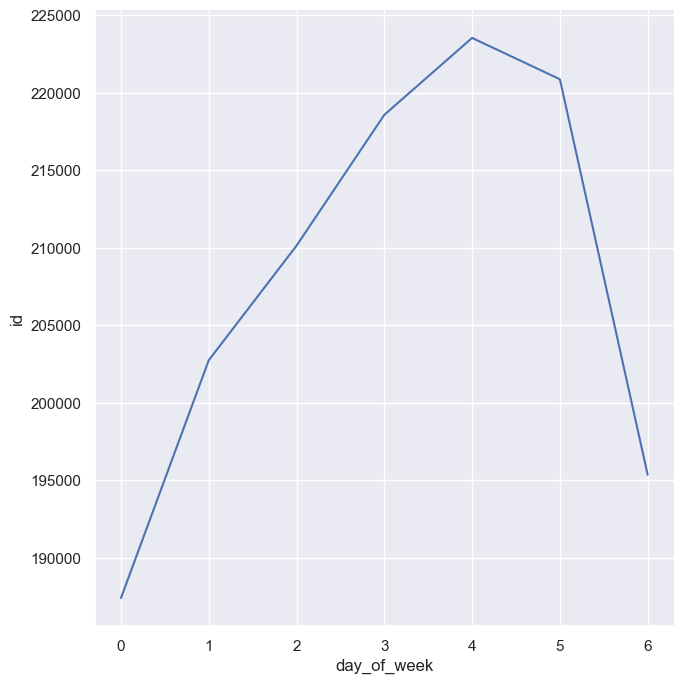

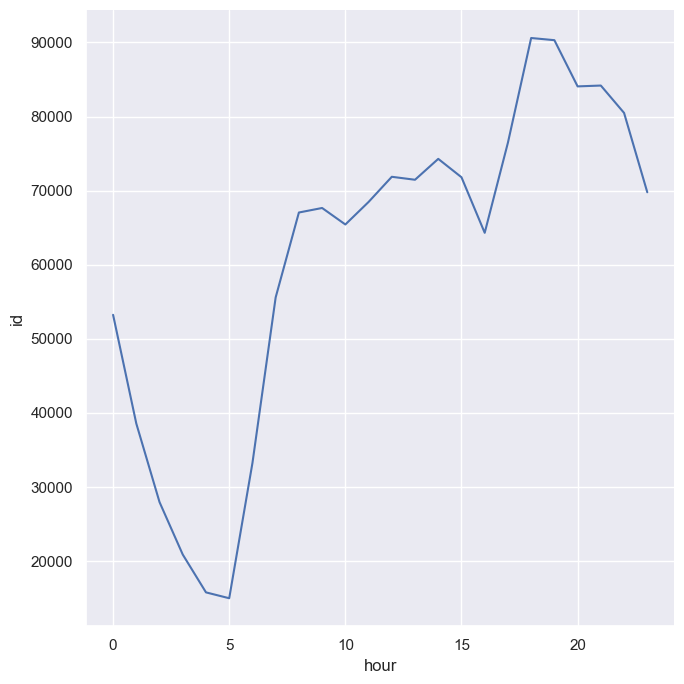

In [284]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

day_of_week = pd.DataFrame(train.groupby('day_of_week').agg({'id':'count'}).reset_index())
sns.relplot(data=day_of_week, x=day_of_week['day_of_week'], y=day_of_week['id'], kind="line", height=7)

hour = pd.DataFrame(train.groupby('hour').agg({'id':'count'}).reset_index())
sns.relplot(data=hour, x=hour['hour'], y=hour['id'], kind="line", height=7)


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [285]:
train['month'] = train['pickup_datetime'].dt.month_name()
train['day_of_week'] = train['pickup_datetime'].dt.day_name()

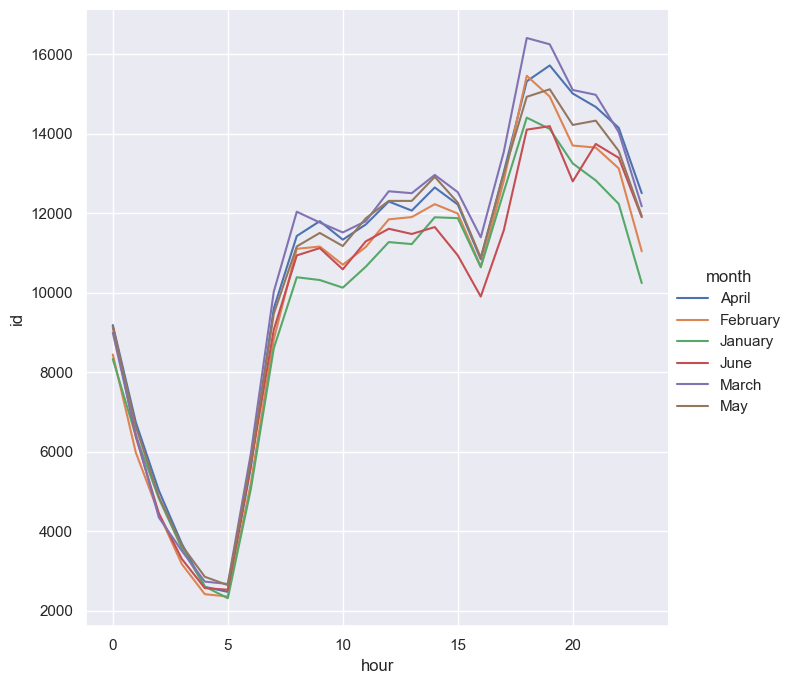

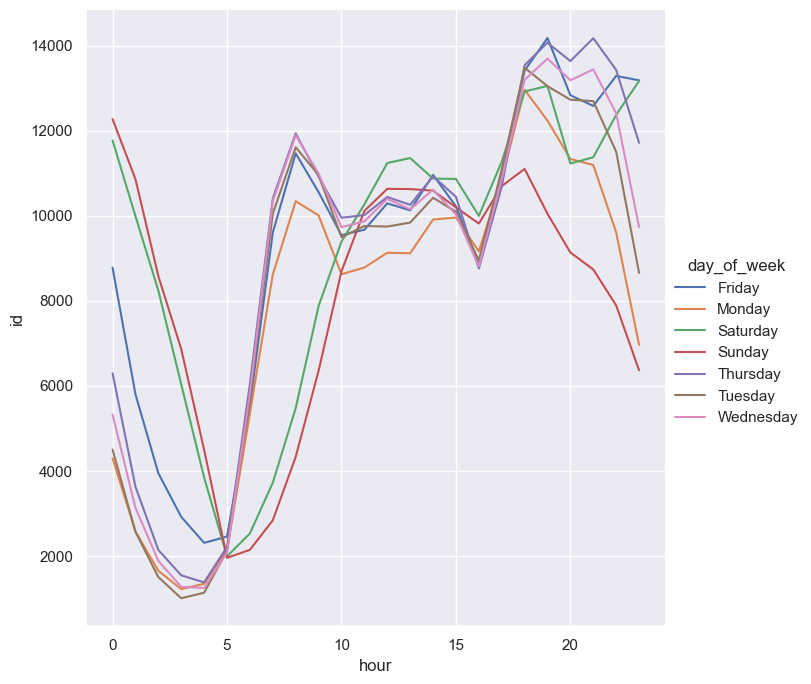

In [286]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

df1 = train.groupby(['month', 'hour']).agg({'id':'count'}).reset_index()
sns.relplot(data=hour, x=df1['hour'], y=df1['id'], hue=df1['month'], kind="line", height=7)
df2 = train.groupby(['day_of_week', 'hour']).agg({'id':'count'}).reset_index()
sns.relplot(data=hour, x=df2['hour'], y=df2['id'], hue=df2['day_of_week'], kind="line", height=7)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: На первом графике днем-вечером кол-во поездок растет от января и июня к весенним месяцам. Думаю, в январе меньше ездили, потому что слишком загруженные дороги из-за погоды и так, а в июне, потому что тепло и можно прогуляться:) В вечерние часы, естественно, больше поездок, так как все возвращаются с работы или едут в ресторан, например. Это на обоих графиках прослеживается. На втором графике интереснее - ночных поездок больше в выходные, потому что все тусуются и возвращаются домой. И, соответственно, в будни ранних поездок утром больше - все едут на работу. 

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [287]:
y = train['log_trip_duration']
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month

In [288]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

In [289]:
log_weekday = X_train.groupby('day_of_week').agg({'log_trip_duration':'mean'}).reset_index()
log_hour = X_train.groupby('hour').agg({'log_trip_duration':'mean'}).reset_index()
log_yearday = X_train.groupby('day_of_year').agg({'log_trip_duration':'mean'}).reset_index()

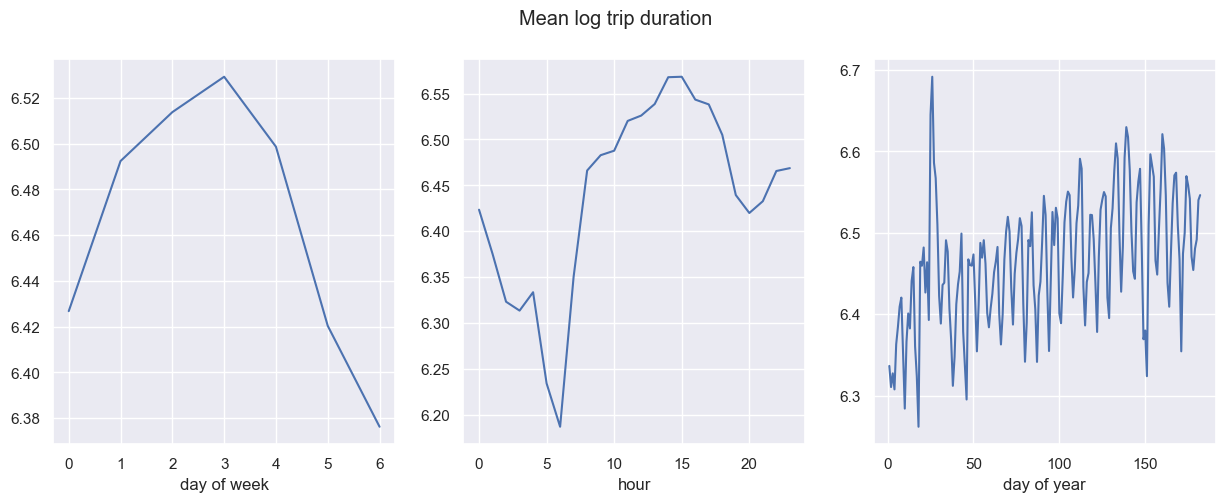

In [290]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
f.suptitle('Mean log trip duration')
ax[0].plot(log_weekday['day_of_week'], log_weekday['log_trip_duration'])
ax[0].set_xlabel('day of week')
ax[1].plot(log_hour['hour'], log_hour['log_trip_duration'])
ax[1].set_xlabel('hour')
ax[2].plot(log_yearday['day_of_year'], log_yearday['log_trip_duration'])
ax[2].set_xlabel('day of year')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Да, графики зависимости таргета от дня недели и от часа в сутках очень похожи на аналогичные графики для количества поездок. Здесь прослеживается простая прямопропорциональная связь между стоимостью и длительностью поездок. 
В первый аномальный период - январь 2016 - средняя (лог)длительность поездки выше, чем обычно. В тот момент была сильная метель и снегопад, поэтому, конечно, ехать было сложнее и дольше. Во второй период - конец мая, начало июня - средняя (лог)длительность поездки ниже остальных (хотя еще ниже было в самом начале января и еще несколько раз). Это можно связать с ----
По поводу тренда на графике относительно дня в году можно заметить, что длительность поездки почти равномерно растет параллельно с тем, как меняются времена года от зимы к лету. 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [291]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# сделано до train_test_split, чтобы эти признаки были и в обучающей, и в тестовой выборках сразу

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ**: как численные: никакие
как категориальные: все 

Ответ такой, потому что номера часов, дней недели, месяцев не несут в себе количественного смысла. С аномалиями соотвественно. 

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [292]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import scipy.stats as st

In [293]:
y = train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

In [294]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
scaler = StandardScaler()
categorical = ['day_of_week', 'hour', 'month','day_of_year']
numeric_features = ['anomaly']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Ridge(1.0))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))




Train RMSE = 0.7880


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [295]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [296]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [297]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ**: Нужно взять во внимание JFK аэропорт и LaGuardia аэропорт, поскольку пути с такими точками посадки и высадки односторонние, в смысле они либо ведут на Манхэттен, либо из Манхэттена, при этом это достаточно важные пункты для поездок. В остальных местах, кроме самого острова Манхэттен, точек совсем немного, и они не слишком показательны.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [298]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [299]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [300]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[:, 'log_haversine'] = np.log1p(train.loc[:, 'haversine'].values)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [301]:
your_df = train
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [302]:
y = train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

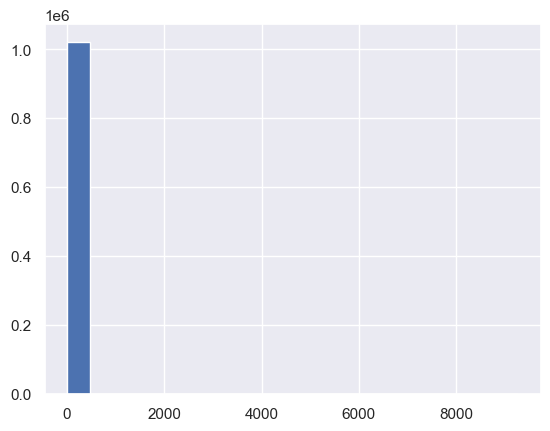

In [303]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.loc[:, 'average_velocity'] = X_train.loc[:, 'haversine'].values / (X_train.loc[:, 'trip_duration'].values / 3600)
plt.hist(X_train.loc[:, 'average_velocity'].values, bins=20)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

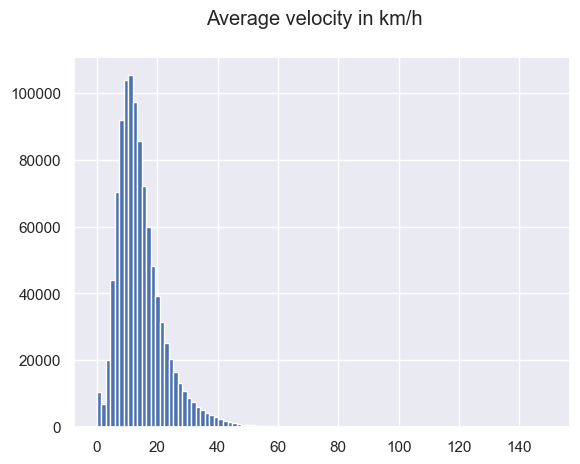

In [304]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(X_train.loc[X_train['average_velocity'] < 150, 'average_velocity'].values, bins=100)
plt.suptitle('Average velocity in km/h')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

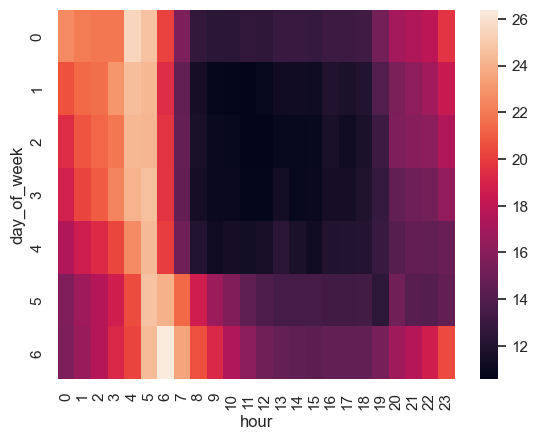

In [305]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
median_velocity = X_train.pivot_table(values='average_velocity', index='day_of_week', columns='hour', aggfunc='mean')
sns.heatmap(median_velocity)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Потому что скоротсь напрямую зависит от нашей целевой переменной, а мы хотим ее предсказать, то есть мы не знаем время, чтобы посчитать скорость.

In [306]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.drop(columns=['average_velocity'], inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: максимум скорости достигается в 6 часов утра в воскресенье - что вполне логично, в это время никто никуда не едет, это выходной и раннее утро. При этом в целом в 2-6 утра каждый день скорость больше, чем в остальное время. Минимум скорости достигается в период с 8 утра до 6 часов вечера со понедельника по пятницу.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [307]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[:, 'trafic'] = 0
train.loc[(7 <= train['hour']) & (train['hour'] <= 18) & (train['day_of_week'] <= 4), 'trafic'] = 1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [308]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


train.loc[:, 'start'] = 'elsewhere'
train.loc[:, 'finish'] = 'elsewhere'


jfk = (40.63972, -73.77889)
laguardia = (40.775, -73.875)
tol = 1e-3

train.loc[np.isclose(train['pickup_latitude'], jfk[0], tol) & np.isclose(train['pickup_longitude'], jfk[1], tol), 'start'] = 'JFK'
train.loc[np.isclose(train['pickup_latitude'], laguardia[0], tol) & np.isclose(train['pickup_longitude'], laguardia[1], tol), 'start'] = 'LaGuardia'
train.loc[np.isclose(train['dropoff_latitude'], jfk[0], tol) & np.isclose(train['dropoff_longitude'], jfk[1], tol), 'finish'] = 'JFK'
train.loc[np.isclose(train['dropoff_latitude'], laguardia[0], tol) & np.isclose(train['dropoff_longitude'], laguardia[1], tol), 'finish'] = 'LaGuardia'





Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

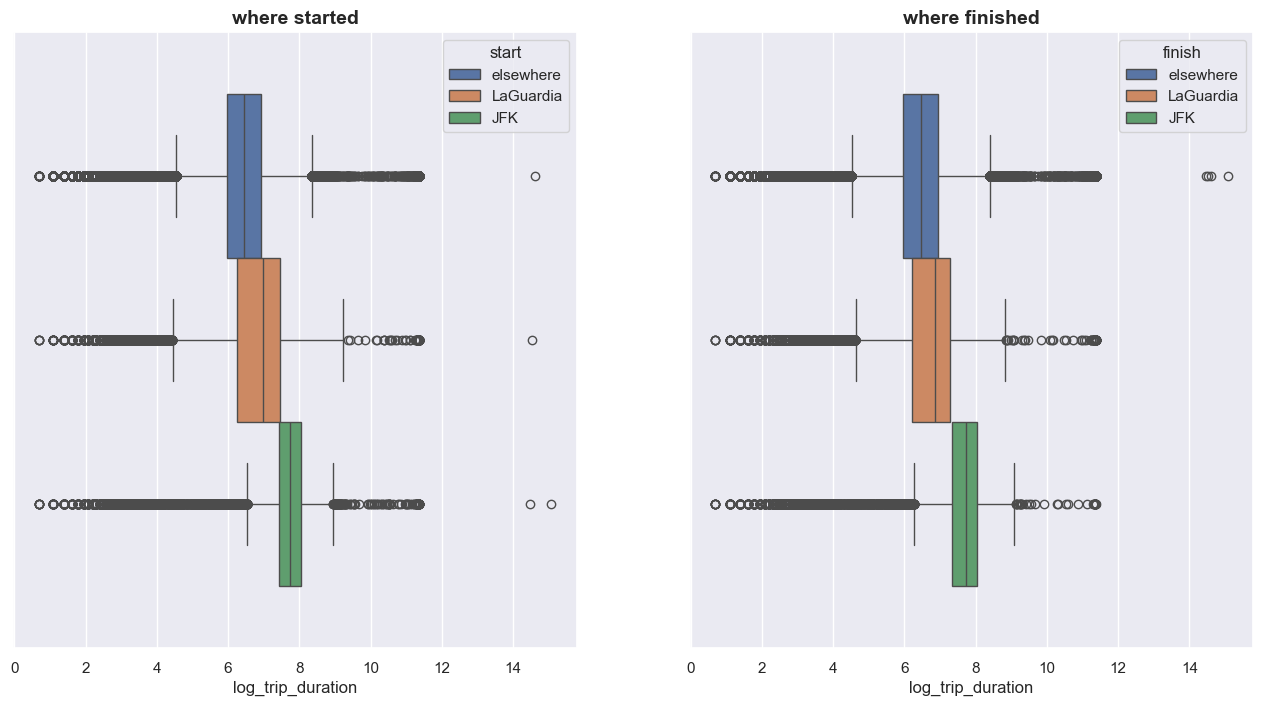

In [309]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

f, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].set_title('where started', size=14,fontweight='bold')
axes[1].set_title('where finished', size=14,fontweight='bold')

sns.boxplot(x=train.loc[:, 'log_trip_duration'], hue=train.loc[:, 'start'], ax=axes[0])
sns.boxplot(x=train.loc[:, 'log_trip_duration'], hue=train.loc[:, 'finish'], ax=axes[1])

plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: основная масса для аэропортов отличается между собой и с остальными территориями, так что, вполне хорошие

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [310]:
from sklearn.base import BaseEstimator, TransformerMixin

In [311]:
# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, coordinates, rows, cols):
        self.cors = coordinates
        self.vert = np.abs(self.cors.ul[0] - self.cors.dr[0]) / rows
        self.hor = np.abs(self.cors.dr[1] - self.cors.ul[1]) / cols
        self.num_items = cols * rows

    
    def show_map(self, data):
        
        location = (data['pickup_latitude'].mean(), data['pickup_longitude'].mean())
        m = folium.Map(location=location)
    
        folium.Rectangle(
                    [self.cors.ul, self.cors.dr],
                ).add_to(m)
        
        for point in self.items:
            folium.Rectangle([point[0], point[1]]).add_to(m)
        
        
        colors = [
            'red',
            'gray',
            'darkred',
            'darkgreen',
            'black',
            'orange',
            'pink',
            'green',
            'darkblue',
            'yellow',
            'lightgreen',
            'purple',
            'blue']
        
        for i in range(self.num_items):
            for index, row in data[data['pickup']==i].iterrows():
                folium.Circle(
                    radius=50,
                    location=(row['pickup_latitude'], row['pickup_longitude']),
                    color=colors[i],
                ).add_to(m)
                
            for index, row in data[data['dropoff']==i].iterrows():
                folium.Circle(
                    radius=50,
                    location=(row['dropoff_latitude'], row['dropoff_longitude']),
                    color=colors[i],
                ).add_to(m)
                
                
        
        display(m)

    def fit(self, X=None, y=None):
        self.items = np.zeros((12, 2, 2))
        for i in range(self.num_items):
            self.items[i][0] = [self.cors.ul[0] - self.vert * (i//3), self.cors.ul[1] + self.hor * (i - i//3*3)%4]
            self.items[i][1] = [self.items[i][0][0] - self.vert, self.items[i][0][1] + self.hor]
            

    def transform(self, X, y=None):
        df = X.copy()
        df.loc[:, 'pickup'] = -1
        df.loc[:, 'dropoff'] = -1
        for i in range(self.num_items):
            item = self.items[i]
            df.loc[(df['pickup_latitude'] >= item[1][0]) & (df['pickup_latitude'] <= item[0][0]) & (df['pickup_longitude'] <= item[1][1]) & (df['pickup_longitude'] >= item[0][1]), 'pickup'] = i
            df.loc[(df['dropoff_latitude'] >= item[1][0]) & (df['dropoff_latitude'] <= item[0][0]) & (df['dropoff_longitude'] <= item[1][1]) & (df['dropoff_longitude'] >= item[0][1]), 'dropoff'] = i
        return df


In [312]:
class Coordinates:
    def __init__(self, ul_lat, ul_long, dr_lat, dr_long):
        self.ul = [ul_lat, ul_long]
        self.dr = [dr_lat, dr_long]

coordinates = Coordinates(ul_lat=40.80873054123304, ul_long=-74.02, dr_lat=40.710081379860886, dr_long=-73.93)

In [313]:
transformer = MapGridTransformer(coordinates, 4, 3)
transformer.fit()
x = transformer.transform(train.sample(500))
transformer.show_map(x)

In [314]:
train = transformer.transform(train)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [315]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

y = train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('anomaly', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('day_of_year', StandardScaler(), numeric_features)
])

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Ridge(1.0))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
y_test_pred = model.predict(X_test[categorical+numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))




Train RMSE = 0.4757
Test RMSE = 0.4754


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: Кажется, что количество пассажиров ну совсем не влияет на длительность поездки, потому что точки посадки и высадки все равно одни и машина от нагрузки в даже 6 человек медленнее ехать не начинает. Провайдер и запись о поездке тоже не очень влияют на длительность чисто по логике. 

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [316]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

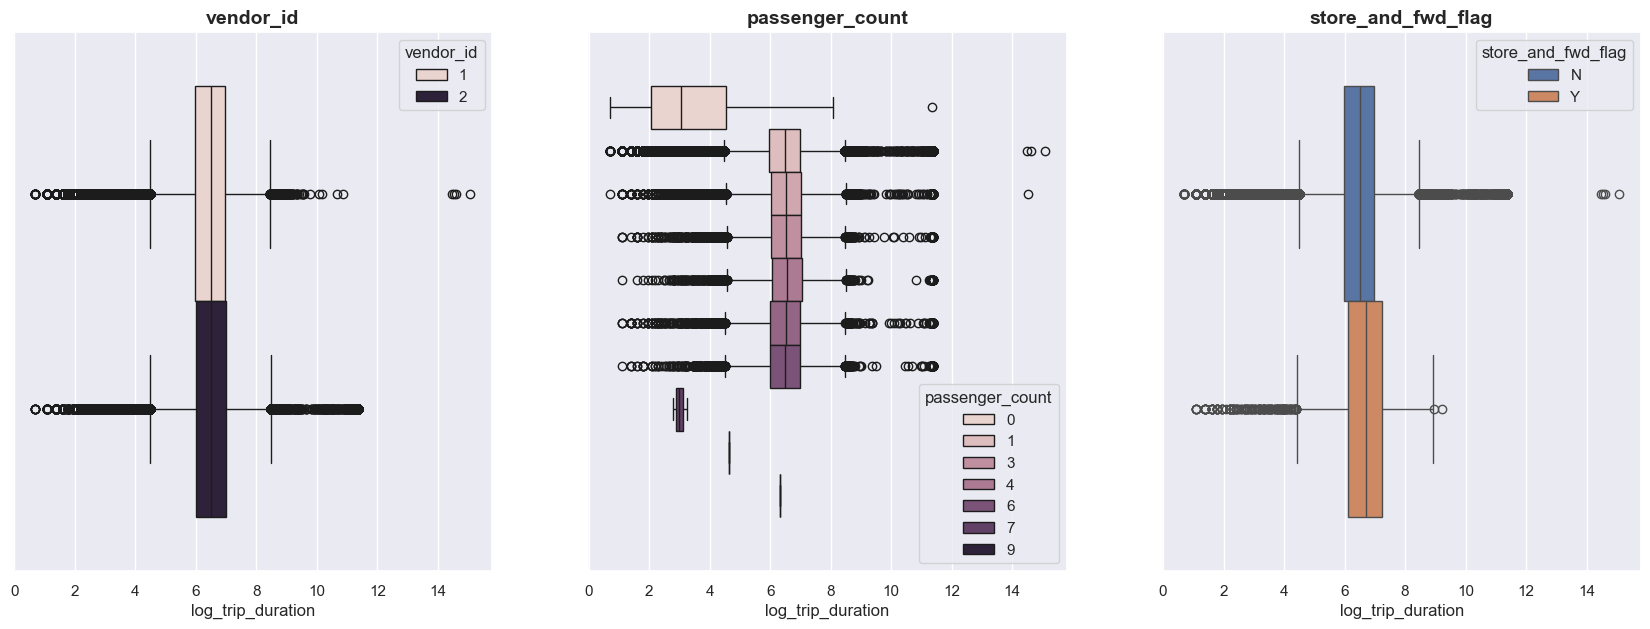

In [317]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
f, axes = plt.subplots(1, 3, figsize=(21, 7))
axes[0].set_title('vendor_id', size=14,fontweight='bold')
axes[1].set_title('passenger_count', size=14,fontweight='bold')
axes[2].set_title('store_and_fwd_flag', size=14,fontweight='bold')

sns.boxplot(data=train, x='log_trip_duration', hue='vendor_id', ax=axes[0])
sns.boxplot(data=train, x='log_trip_duration', hue='passenger_count', ax=axes[1])
sns.boxplot(data=train, x='log_trip_duration', hue='store_and_fwd_flag', ax=axes[2])
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [318]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[:, 'vendor_id'] -= 1
train.loc[:, 'store_and_fwd_flag'].replace({'N':0, 'Y':1}, inplace=True)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Графики не показывают сильных различий в зависимости от выбранных признаков и их категорий, кроме случая, когда количество пассажиров - 0 (это скорее всего неверные данные). Поэтому кажется, что признаки совсем не показательны.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [319]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['log_haversine']


column_transformer = ColumnTransformer([
    ('anomaly', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('day_of_year', StandardScaler(), numeric_features)
])

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Ridge(1.0))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
y_test_pred = model.predict(X_test[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))



Train RMSE = 0.4753
Test RMSE = 0.4749


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [320]:
train.drop(columns=['vendor_id', 'store_and_fwd_flag', 'passenger_count'], inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [321]:
X_train.loc[:, 'abs_residuals'] = np.abs(X_train.loc[:, 'log_trip_duration'] - y_train_pred)

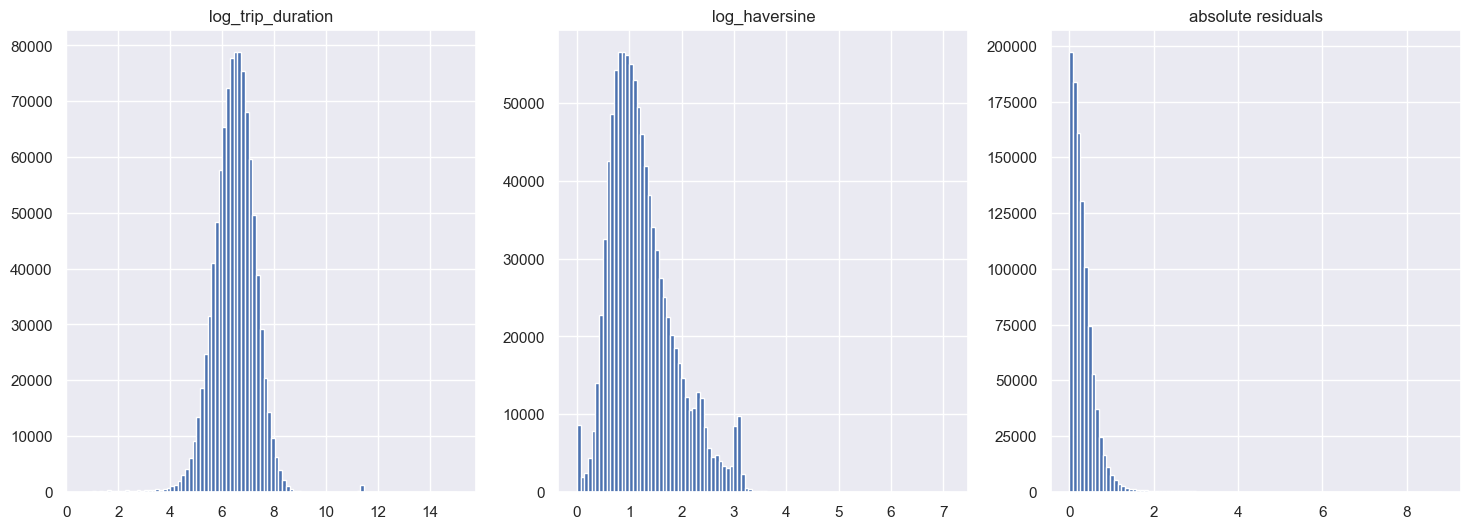

In [322]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

f, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist(X_train.loc[:, 'log_trip_duration'], bins=100)
ax[0].set_title('log_trip_duration')
ax[1].hist(X_train.loc[:, 'log_haversine'], bins=100)
ax[1].set_title('log_haversine')
ax[2].hist(X_train.loc[:, 'abs_residuals'], bins=100)
ax[2].set_title('absolute residuals')
plt.show()

In [323]:

X_train.loc[:, 'z_residuals'] = np.abs(st.zscore(X_train.loc[:, 'abs_residuals'].values))
X_train.loc[:, 'z_duration'] = np.abs(st.zscore(X_train.loc[:, 'log_trip_duration'].values))
X_train.loc[:, 'z_haversine'] = np.abs(st.zscore(X_train.loc[:, 'log_haversine'].values))

In [324]:

X_train = X_train.loc[X_train['abs_residuals'] < 3]
X_train = X_train.loc[X_train['z_duration'] < 3]
X_train = X_train.loc[X_train['z_haversine'] < 3]


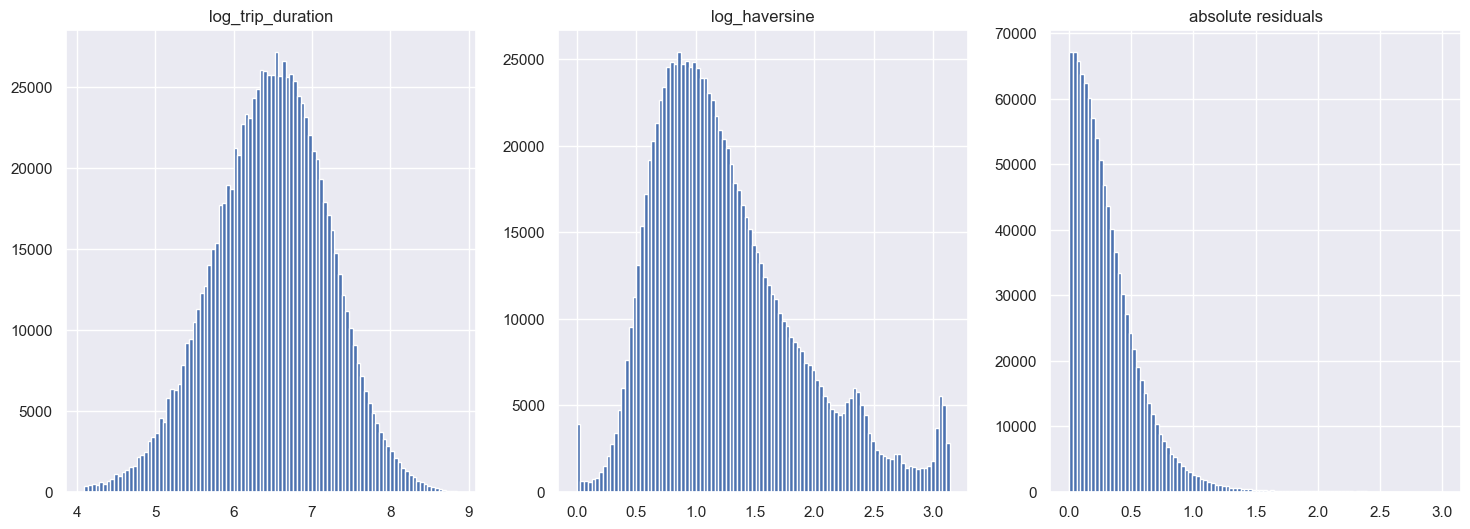

In [325]:
f, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist(X_train.loc[:, 'log_trip_duration'], bins=100)
ax[0].set_title('log_trip_duration')
ax[1].hist(X_train.loc[:, 'log_haversine'], bins=100)
ax[1].set_title('log_haversine')
ax[2].hist(X_train.loc[:, 'abs_residuals'], bins=100)
ax[2].set_title('absolute residuals')
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

In [326]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.drop(columns=['z_residuals', 'z_duration','z_haversine'], inplace=True)

In [327]:
y_train = X_train['log_trip_duration'].copy()
scaler = StandardScaler()
categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Ridge(0.14))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
y_test_pred = model.predict(X_test[categorical+numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))



Train RMSE = 0.4048
Test RMSE = 0.4764


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [328]:
#╰( ͡° ͜ʖ ͡° )

# до ohe - 14
# после ohe - 269
column_transformer.transform(X_train[categorical+numeric_features]).shape

(1009857, 269)

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [329]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Lasso(0.1))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
y_test_pred = model.predict(X_test[categorical+numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))



Train RMSE = 0.4672
Test RMSE = 0.5402


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [330]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42 )


In [331]:
from sklearn.model_selection import GridSearchCV

In [332]:
#Lasso
alphas = np.logspace(-1, 1, 11)
cv = GridSearchCV(Lasso(), [{"alpha" : alphas}], scoring = "neg_root_mean_squared_error", cv = 5, n_jobs =-1, verbose =1)
pipeline = Pipeline(steps=[
    ("ohe_and_scale", column_transformer),
    ("cv", cv)
])
modelLasso = pipeline.fit(X_train2[categorical + numeric_features], X_train2["log_trip_duration"])

best_alpha_Lasso = cv.best_params_["alpha"]
y_pred = modelLasso.predict(X_val[categorical + numeric_features])

print("Best alpha for Lasso= %.6f" % best_alpha_Lasso)
print("Val RMSE = %.4f after Lasso" % mean_squared_error(y_val, y_pred, squared=False))


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best alpha for Lasso= 0.100000
Val RMSE = 0.4672 after Lasso


In [333]:
#Ridge
alphas = np.logspace(-1, 1, 11)
cv = GridSearchCV(Ridge(), [{"alpha" : alphas}], scoring = "neg_root_mean_squared_error", cv = 5, n_jobs =-1, verbose =1)
pipeline = Pipeline(steps=[
    ("ohe_and_scale", column_transformer),
    ("cv", cv)
])
modelRidge = pipeline.fit(X_train2[categorical + numeric_features], X_train2["log_trip_duration"])

best_alpha_Ridge = cv.best_params_["alpha"]
y_pred = modelRidge.predict(X_val[categorical + numeric_features])

print("Best alpha for Ridge= %.6f" % best_alpha_Ridge)
print("Val RMSE = %.4f after Ridge" % mean_squared_error(y_val, y_pred, squared=False))


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best alpha for Ridge= 10.000000
Val RMSE = 0.4051 after Ridge


In [334]:
y_test_pred_Ridge = modelRidge.predict(X_test[categorical + numeric_features])
y_test_pred_Lasso = modelLasso.predict(X_test[categorical + numeric_features])
print("Test RMSE = %.4f after Ridge" % mean_squared_error(y_test, y_test_pred_Ridge, squared=False))
print("Test RMSE = %.4f after Lasso" % mean_squared_error(y_test, y_test_pred_Lasso, squared=False))

Test RMSE = 0.4764 after Ridge
Test RMSE = 0.5402 after Lasso


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

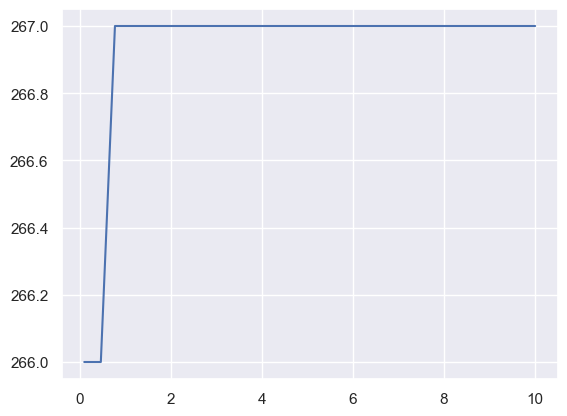

In [335]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

alphas = np.logspace(-1, 1, 10)
x = np.zeros(10)
for i, alpha in enumerate(alphas):
    pipeline = Pipeline(steps=[
        ("ohe_and_scale", column_transformer),
        ("regression", Lasso(alpha))
    ])
    modelLasso = pipeline.fit(X_train2[categorical + numeric_features], X_train2["log_trip_duration"])
    x[i] = np.count_nonzero(modelLasso['regression'].coef_==0.0)

plt.plot(alphas, x)
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [336]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
trajectory = train.loc[(train['pickup'] != -1) & (train['dropoff'] != -1)].groupby(['pickup', 'dropoff']).agg({'id':'count'}).reset_index().sort_values(by='id', ascending=False).head(100).reset_index()

train.loc[:, 'trajectory'] = -1
for i in range(100):
    train.loc[(train['pickup'] == trajectory.loc[i, 'pickup']) & (train['dropoff'] == trajectory.loc[i, 'dropoff']), 'trajectory'] = i


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [337]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42 )

In [338]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

scaler = StandardScaler()
categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'trajectory']
numeric_features = ['log_haversine']
column_transformer = ColumnTransformer([
    ('anomaly', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('day_of_year', StandardScaler(), numeric_features)
])
simple_pipeline = Pipeline([
    ('ohe_scaling', column_transformer),
    ('regression', Ridge(best_alpha_Ridge))
])

model = simple_pipeline.fit(X_train[categorical+numeric_features], y_train)
y_train_pred = model.predict(X_train[categorical+numeric_features])
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
y_test_pred = model.predict(X_test[categorical+numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))



Train RMSE = 0.4647
Test RMSE = 0.4645


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [339]:
# оси

Oxy = np.array([[40.81652993719501, -73.94659179253874], [40.73129577494412, -74.00851824955521], [40.742135568119764, -74.00821387088125],[40.72721923117832, -73.97243794835732]])


Ox = (Oxy[1] - Oxy[0])
Oy = (Oxy[3] - Oxy[2])

In [340]:
# Oxy = np.array([[40.81652993719501, -73.94659179253874], [40.73129577494412, -74.00851824955521], [40.742135568119764, -74.00821387088125],[40.72721923117832, -73.97243794835732]])
# location = (Oxy[:, 0].mean(), Oxy[:, 1].mean())
# m = folium.Map(location=location)
# folium.PolyLine(Oxy[:2], color="red", weight=2.5, opacity=1).add_to(m)
# folium.PolyLine(Oxy[2:], color="red", weight=2.5, opacity=1).add_to(m)
# display(m)


ссылка на картинку с осями
https://disk.yandex.com/d/S3L6skM71XHHmA

In [341]:
def distance_point_to_vector(point, vector):
    point = np.array(point)
    vector = np.array(vector)
    normalized_vector = vector / np.linalg.norm(vector)
    projection = np.dot(point, normalized_vector) * normalized_vector
    distance = np.linalg.norm(point - projection)
    return distance * 260


def compute_man_dist(row):
  point_1 = [row['pickup_latitude'], row['pickup_longitude']]
  point_2 = [row['dropoff_latitude'], row['dropoff_longitude']]
  dist_1 = np.array((distance_point_to_vector(point_1, Ox), distance_point_to_vector(point_1, Oy)))
  dist_2 = np.array((distance_point_to_vector(point_2, Ox), distance_point_to_vector(point_2, Oy)))
  return sum(abs(dist_2-dist_1))



In [342]:
train['manhattan_dist'] = train[['pickup_longitude', 'pickup_latitude',	'dropoff_longitude', 'dropoff_latitude']].apply(compute_man_dist, axis=1)
train['log_manhattan_dist'] = np.log1p(train['manhattan_dist'])

<Axes: >

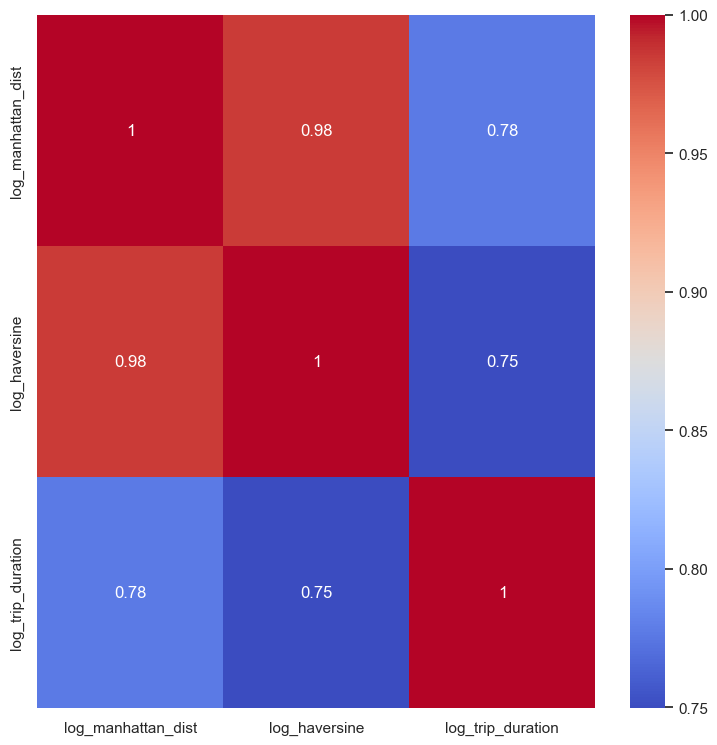

In [343]:
# здесь видно, что умножение манхэттенского расстояния на 275 обеспечило корреляцию с log haversine равную почти 1
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(train[['log_manhattan_dist', 'log_haversine', 'log_trip_duration']].corr(), annot=True, fmt='.2g', cmap='coolwarm', axes=ax)


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [344]:
X_train, X_test, y_train, y_test = train_test_split(train, train['log_trip_duration'], test_size=0.3, random_state=42)

categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'trajectory']
numeric_features = ['log_manhattan_dist']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)

])
pipeline = Pipeline(steps=[
    ("ohe_and_scale", column_transformer),
    ('regression', Ridge(10))
])
model_ridge = pipeline.fit(X_train[categorical + numeric_features], y_train)
y_pred = model_ridge.predict(X_test[categorical + numeric_features])
print("Test Ridge RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test Ridge RMSE = 0.4435


**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [345]:
# !pip install h3
# !pip install h3pandas
import h3pandas

In [356]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
pickup = train[['id', 'pickup_longitude',  'pickup_latitude']].rename(columns={'pickup_longitude': 'lng', 'pickup_latitude': 'lat'})
dropoff = train[['id', 'dropoff_longitude', 'dropoff_latitude']].rename(columns={'dropoff_longitude': 'lng', 'dropoff_latitude': 'lat'})
for_pickup = pickup.h3.geo_to_h3(10).reset_index()
for_dropoff = dropoff.h3.geo_to_h3(10).reset_index()


In [358]:
for_pickup.rename(columns = {'h3_10': 'h3_pickup'}, inplace=True)
for_dropoff.rename(columns = {'h3_10': 'h3_dropoff'}, inplace=True)


In [359]:
new_train = pd.merge(pd.merge(train, for_pickup, how='left', on='id'), for_dropoff, on='id', how='left')

In [361]:

X_train, X_test, y_train, y_test = train_test_split(new_train, new_train['log_trip_duration'], test_size=0.3, random_state=42)
categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'trajectory', 'h3_pickup', 'h3_dropoff']
numeric_features = ['log_manhattan_dist', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)

])
pipeline = Pipeline(steps=[
    ("ohe_and_scale", column_transformer),
    ('regression', Ridge(10))
])
model_ridge = pipeline.fit(X_train[categorical + numeric_features], X_train['log_trip_duration'])
y_pred = model_ridge.predict(X_test[categorical + numeric_features])
print("Test Ridge RMSE = %.4f " % mean_squared_error(y_test, y_pred, squared=False))

Test Ridge RMSE = 0.4285 


In [362]:
# 100 самых частопосещаемых прямоугольников

same_path = new_train.loc[(new_train['h3_pickup'] != -1) & (new_train['h3_dropoff'] != -1)].groupby(['h3_pickup', 'h3_dropoff']).agg({'id':'count'}).reset_index().sort_values(by='id').tail(100).reset_index()

new_train.loc[:, 'same_path_h3'] = -1
for i in range(100):
    new_train.loc[(new_train['h3_pickup'] == same_path.loc[i, 'h3_pickup']) & (new_train['h3_dropoff'] == same_path.loc[i, 'h3_dropoff']), 'same_path_h3'] = i

In [363]:
# совпадают точки начала и конца поездки
new_train['pickup_dropoff_same'] = -1
new_train.loc[(new_train['pickup_latitude'] == new_train['dropoff_latitude']) & (new_train['pickup_longitude'] == new_train['dropoff_longitude']), 'pickup_dropoff_same'] = 0


In [364]:

X_train, X_test, y_train, y_test = train_test_split(new_train, new_train['log_trip_duration'], test_size=0.3, random_state=10)

categorical = ['anomaly', 'day_of_week', 'day_of_year', 'hour', 'month', 'start', 'finish', 'pickup', 'dropoff', 'trafic', 'trajectory', 'h3_pickup', 'h3_dropoff', 'pickup_dropoff_same']
numeric_features = ['log_manhattan_dist', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)

])
pipeline = Pipeline(steps=[
    ("ohe_and_scale", column_transformer),
    ('regression', Ridge(10))
])
model_ridge = pipeline.fit(X_train[categorical + numeric_features], X_train['log_trip_duration'])
y_pred = model_ridge.predict(X_test[categorical + numeric_features])
print("Test Ridge RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test Ridge RMSE = 0.4233


In [ ]:
# ошибка в 16 задании - 0.4435, здесь 0.4233 => уменьшилась на 0.202

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.